In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import torch.nn          as nn
import seaborn           as sns
import libraries.model   as glm
import libraries.dataset as gld
import torch
import json
import os
import sys

from torch_geometric.loader import DataLoader
from matplotlib.colors      import Normalize
from matplotlib             import cm

# Set colormap
cmap = plt.get_cmap('plasma')

sns.set_theme()

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# Define name of data folder where reference dataset are contained
# It shall be consistent with data_folder and data will be moved to models folder
data_name = 'Loaded_QM9_gap-sphere-images'  # 'Loaded_MP_bandgap-sphere-images', 'MChX'

# Define folder in which data is stored
data_folder = f'data/{data_name}'

# The folder is named as target_folder_vi (eg, target_folder_v0)
general_folder = f'models/{data_name}'
if not os.path.exists(general_folder):
    # Generate new folder
    os.system(f'mkdir {general_folder}')

target_folder = None  # None, 'models/MChX/GM_v0'
if target_folder is None:
    # Each new run generates a new folder, with different generations and training most likely (as data might vary as well)
    i = 0
    while True:
        target_folder = f'{general_folder}/GM_v{i}'
        if not os.path.exists(target_folder):
            # Copy all data
            os.system(f'cp -r {data_folder} {target_folder}')
            break
        i += 1

model_name = f'{target_folder}/model.pt'
target_folder

'models/Loaded_QM9_gap-sphere-images/GM_v3'

In [3]:
# Machine-learning parameters
n_epochs      = 2000
batch_size    = 256
learning_rate = 0.0001
patience      = n_epochs
delta         = 0.2
check_labels  = False  # Whether to train-test split attending to labels or not

n_eras = 10  # Number of training eras to train the model in denoising steps

# Number of diffusing and denoising steps
n_t_steps = torch.tensor(100, dtype=torch.int, device=device)

# Decay of parameter alpha
alpha_decay = torch.tensor(0.0001, device=device)

# Dropouts for node and edge models (independent of each other)
pdropout_node = 0.1
pdropout_edge = 0.1

# Create and save as a dictionary
model_parameters = {
    'data_folder':   data_folder,
    'n_eras':        n_eras,
    'n_epochs':      n_epochs,
    'batch_size':    batch_size,
    'learning_rate': learning_rate,
    'patience':      patience,
    'delta':         delta,
    'check_labels':  check_labels,
    'n_t_steps':     n_t_steps.cpu().numpy().tolist(),
    'alpha_decay':   alpha_decay.cpu().numpy().tolist(),
    'dropout_node':  pdropout_node,
    'dropout_edge':  pdropout_edge
}

# Write the dictionary to the file in JSON format
with open(f'{target_folder}/model_parameters.json', 'w') as json_file:
    json.dump(model_parameters, json_file)

# Load of graph database for training

Load the dataset, already standardized.

In [4]:
dataset_name                = f'{target_folder}/dataset.pt'
dataset_name_std            = f'{target_folder}/standardized_dataset.pt'
dataset_parameters_name_std = f'{target_folder}/standardized_parameters.json'  # Parameters for rescaling the predictions

if os.path.exists(dataset_name_std) and os.path.exists(dataset_parameters_name_std):
    # Load the standardized dataset, with corresponding labels and parameters
    dataset = torch.load(dataset_name_std, weights_only=False)

    # Load the data from the JSON file
    with open(dataset_parameters_name_std, 'r') as json_file:
        numpy_dict = json.load(json_file)

    # Convert NumPy arrays back to PyTorch tensors
    dataset_parameters = {}
    for key, value in numpy_dict.items():
        try:
            dataset_parameters[key] = torch.tensor(value)
        except:
            dataset_parameters[key] = value

elif os.path.exists(dataset_name):
    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(dataset_name, weights_only=False)

    # Standardize dataset
    dataset, dataset_parameters = gld.standardize_dataset(dataset)
    
    # Save standardized dataset
    torch.save(dataset, dataset_name_std)

    # Convert torch tensors to numpy arrays
    numpy_dict = {}
    for key, value in dataset_parameters.items():
        try:
            numpy_dict[key] = value.cpu().numpy().tolist()
        except:
            numpy_dict[key] = value

    # Dump the dictionary with numpy arrays to a JSON file
    with open(dataset_parameters_name_std, 'w') as json_file:
        json.dump(numpy_dict, json_file)

else:
    sys.exit('Error: the database is not available')

# Defining target factor
target_factor = dataset_parameters['target_std'] / dataset_parameters['scale']

Include features and prepare shape of dataset for training, considerably reducing CPU-GPU communication.

In [5]:
# Determine number of graphs in dataset
n_graphs = len(dataset)

# Determine number of node-level features in dataset
n_node_features = dataset[0].num_node_features

# Determine the number of graph-level features to be predicted
n_graph_features = len(dataset[0].y)

# Make room for n_graph_features and t_steps in the dataset
for idx in range(n_graphs):
    dataset[idx] = glm.add_features_to_graph(dataset[idx],
                                             torch.tensor([dataset[idx].y, 0]))

Split in train, validation and test sets

In [6]:
train_ratio = 0.8
test_ratio  = 0.1

# Check if data has been already split, else do it randomly
path_to_train_labels = f'{target_folder}/train_labels.txt'
path_to_val_labels   = f'{target_folder}/validation_labels.txt'
path_to_test_labels  = f'{target_folder}/test_labels.txt'

# Copy labels
material_labels = [graph.label for graph in dataset]

if check_labels:
    if os.path.exists(path_to_train_labels) and os.path.exists(path_to_val_labels) and os.path.exists(path_to_test_labels):
        # Read labels splitting (which are strings)
        train_labels = np.genfromtxt(path_to_train_labels, dtype='str').tolist()
        val_labels   = np.genfromtxt(path_to_val_labels,   dtype='str').tolist()
        test_labels  = np.genfromtxt(path_to_test_labels,  dtype='str').tolist()
    else:
        # Splitting into train-test sets considering that Fvs from the same materials must be in the same dataset
        material_labels = [label.split()[0] for label in material_labels]
        
        # Define unique labels
        unique_labels = np.unique(material_labels)
        
        # Shuffle the list of unique labels
        np.random.shuffle(unique_labels)
    
        # Define the sizes of the train and test sets
        # Corresponds to the size wrt the number of unique materials in the dataset
        train_size = int(train_ratio * len(unique_labels))
        test_size  = int(test_ratio  * len(unique_labels))
        
        train_labels = unique_labels[:train_size]
        val_labels   = unique_labels[train_size:-test_size]
        test_labels  = unique_labels[-test_size:]
    
        # Save this splitting for transfer-learning approaches
        np.savetxt(path_to_train_labels, train_labels, fmt='%s')
        np.savetxt(path_to_val_labels,   val_labels,   fmt='%s')
        np.savetxt(path_to_test_labels,  test_labels,  fmt='%s')

    # Use the computed indexes to generate train and test sets
    # We iteratively check where labels equals a unique train/test labels and append the index to a list
    train_dataset = gld.get_datasets(train_labels, material_labels, dataset)
    val_dataset   = gld.get_datasets(val_labels,   material_labels, dataset)
    test_dataset  = gld.get_datasets(test_labels,  material_labels, dataset)
else:
    # Define the sizes of the train and test sets
    # Corresponds to the size wrt the number of unique materials in the dataset
    train_size = int(train_ratio * len(dataset))
    test_size  = int(test_ratio  * len(dataset))

    np.random.shuffle(dataset)
    
    # Random, fast splitting
    train_dataset = dataset[:train_size]
    val_dataset   = dataset[train_size:-test_size]
    test_dataset  = dataset[-test_size:]

del dataset  # Free up CUDA memory

print(f'Number of training   graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of testing    graphs: {len(test_dataset)}')

Number of training   graphs: 107108
Number of validation graphs: 13389
Number of testing    graphs: 13388


Define data loaders.

In [7]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)
del train_dataset, val_dataset, test_dataset  # Free up CUDA memory

# Definition of the model

In [8]:
# Instantiate the models for nodes and edges, considering the t_step information; n_graph_features+1 for accounting for the time step
model = glm.GNN(n_node_features, n_graph_features, pdropout_node, pdropout_edge).to(device)

# Load previous model if available
try:
    # Load and evaluate model state
    model.load_state_dict(torch.load(model_name, map_location=torch.device(device), weights_only=False))
    model.train()
except FileNotFoundError:
    pass

# Allow data parallelization among multi-GPU
model= nn.DataParallel(model)

print('\nGCNN:')
print(model)


GCNN:
DataParallel(
  (module): GNN(
    (node_conv1): GraphConv(6, 128)
    (node_conv2): GraphConv(128, 256)
    (node_conv3): GraphConv(256, 4)
    (edge_linear_f1): Linear(in_features=13, out_features=128, bias=True)
    (edge_linear_r1): Linear(in_features=128, out_features=1, bias=True)
    (edge_linear_f2): Linear(in_features=257, out_features=256, bias=True)
    (edge_linear_r2): Linear(in_features=256, out_features=1, bias=True)
    (edge_linear_f3): Linear(in_features=513, out_features=128, bias=True)
    (edge_linear_r3): Linear(in_features=128, out_features=1, bias=True)
    (node_norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (edge_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


# Training of the model

In [ ]:
node_attributes_list = ['edge_attr', 'atomic_mass', 'charge', 'electronegativity', 'ionization_energy']

# Initialize the optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize early stopping
early_stopping = glm.EarlyStopping(patience=patience, delta=delta, model_name=model_name)

# Normalize t_step values for plotting
norm = Normalize(vmin=0, vmax=n_t_steps-1)

# Training loop
edge_train_losses = []
node_train_losses = []
for epoch in range(n_epochs):
    # Initialize train loss variable
    edge_loss_cum = 0
    node_loss_cum = np.zeros(n_node_features, dtype=float)
    ground_truth = {k: [] for k in node_attributes_list}
    prediction   = {k: [] for k in node_attributes_list}
    
    fig, ax = plt.subplots(1, len(node_attributes_list), figsize=(13, 2))

    for batch_idx, batch_0 in enumerate(train_loader):
        # Clone batch of graphs and move to device
        g_batch_0 = batch_0.clone().to(device)

        # Start denoising-diffusing process
        for _ in range(n_eras):
            # Generate a random t step
            t_step = torch.randint(0, n_t_steps, (1,))[0]

            # Initialize the gradient of the optimizers
            optimizer.zero_grad()
            
            # Standard normalization for the time step, which is added to node-level graph embeddings after 
            t_step_std = t_step / n_t_steps - 0.5 

            # Diffuse the entire batch of graphs with Gaussian noise
            # Vectorized version of diffusion_step for batching
            g_batch_t, e_batch_t = glm.diffuse_t_steps(g_batch_0,
                                                       t_step, n_t_steps, alpha_decay,
                                                       n_features=n_node_features)
            
            # Stack time step across batch dimension 
            g_batch_t.x[:, -1] = t_step_std
            
            # Predict batch noise at given time step
            pred_epsilon_t = glm.predict_noise(g_batch_t, model)

            # Calculate the losses for node features and edge attributes
            node_losses, edge_loss = glm.get_graph_losses(e_batch_t, pred_epsilon_t)
            
            # Combine losses for each attribute tensors
            node_loss = torch.stack(node_losses).mean()
            
            # Get items
            node_loss_cum += np.array([node_loss.item() for node_loss in node_losses])
            edge_loss_cum += edge_loss.item()
            loss = node_loss + edge_loss
            
            # Backpropagate and optimize node loss
            if not early_stopping.early_stop:
                loss.backward(retain_graph=True)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
                optimizer.step()

            # Randomly sample batches to store data
            if not t_step%1 and batch_idx == 0:
                for key, idx in zip(node_attributes_list, range(n_node_features+1)):
                    # In this order: edge_attr, x0, x1, x2, x3, ... to lists
                    gt_value   = (     e_batch_t.edge_attr if not idx else      e_batch_t.x[:, idx-1]).cpu().detach().numpy().tolist()
                    pred_value = (pred_epsilon_t.edge_attr if not idx else pred_epsilon_t.x[:, idx-1]).cpu().detach().numpy().tolist()

                    # Append to dictionaries
                    ground_truth[key].append(gt_value)
                    prediction[key].append(pred_value)

                    ax[idx].plot(gt_value, pred_value, '.', color=cmap(((t_step + 1) / n_t_steps).cpu().detach().numpy()))

    # Add a colorbar to the figure
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax.ravel().tolist(), orientation="vertical", label="t_step")

    # Plot once per epoch
    for idx, item in enumerate(ground_truth):
        gt_values   = np.concatenate(ground_truth[item])
        pred_values = np.concatenate(prediction[item])
        
        _min, _max = min(gt_values.min(), pred_values.min()), max(gt_values.max(), pred_values.max())
        ax[idx].plot([_min, _max], [_min, _max], '-r')
    plt.show()

    # Compute the average train loss over n_t_steps
    node_loss_cum /= (n_eras * len(train_loader))
    edge_loss_cum /= (n_eras * len(train_loader))

    # Append average losses
    node_train_losses.append(node_loss_cum)
    edge_train_losses.append(edge_loss_cum)

    # Check early stopping criteria
    early_stopping(node_loss_cum.sum()+edge_loss_cum, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print_node_loss = ' '.join([f'{node_loss:.4f}' for node_loss in node_loss_cum])
    print(f'Epoch: {epoch+1}, edge loss: {edge_loss_cum:.4f}, node loss: {print_node_loss}')

In [10]:
rescaled_edge_train_losses = np.sqrt(edge_train_losses) * dataset_parameters['edge_std'].numpy() + dataset_parameters['edge_mean'].numpy()
rescaled_edge_train_losses

array([693.87097859,   5.65976248,   4.81956747, ...,   3.15460744,
         3.15560212,   3.15464511], shape=(2000,))

In [11]:
node_train_losses = np.array(node_train_losses)
rescaled_node_loss_cum = np.sqrt(node_train_losses) * dataset_parameters['feat_std'].numpy() + dataset_parameters['feat_mean'].numpy()
rescaled_node_loss_cum

array([[1.08862807e+07, 1.93447357e+07, 1.39076921e+06, 1.86611116e+06],
       [1.19909029e+04, 8.49349480e+03, 1.08469742e+03, 2.72114847e+03],
       [1.17234332e+04, 9.04917583e+03, 8.20026828e+02, 2.83092148e+03],
       ...,
       [7.02879019e+00, 3.75767307e+00, 2.48457280e+00, 1.28524125e+01],
       [7.02991666e+00, 3.75839373e+00, 2.48463174e+00, 1.28525829e+01],
       [7.02927515e+00, 3.75795422e+00, 2.48460417e+00, 1.28524713e+01]],
      shape=(2000, 4))

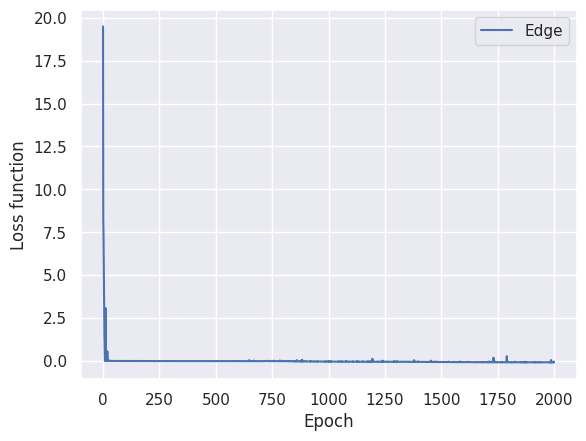

In [12]:
plt.plot(np.log(edge_train_losses), label='Edge')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='best')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


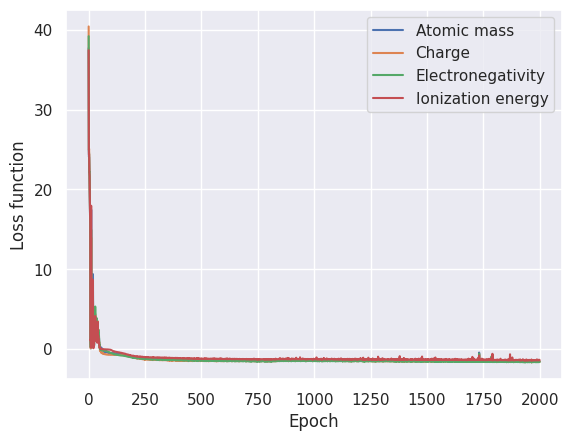

In [13]:
plt.plot(np.log(np.array(node_train_losses)[:, 0]), label=f'Atomic mass')
plt.plot(np.log(np.array(node_train_losses)[:, 1]), label=f'Charge')
plt.plot(np.log(np.array(node_train_losses)[:, 2]), label=f'Electronegativity')
plt.plot(np.log(np.array(node_train_losses)[:, 3]), label=f'Ionization energy')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='best')
plt.savefig('Losses.eps', dpi=50, bbox_inches='tight')
plt.show()

# Test of the model

In [14]:
# Set eval
model.eval()

# Training loop
edge_test_losses = 0
node_test_losses = np.zeros(n_node_features, dtype=float)
with torch.no_grad():
    for batch_idx, batch_0 in enumerate(test_loader):
        # Move batch to device
        batch_0 = batch_0.to(device)
        
        # Clone batch of graphs and move to device
        g_batch_0 = batch_0.clone()
        
        # Diffuse batch
        g_batch_t, _ = glm.diffuse_t_steps(g_batch_0,
                                           n_t_steps, n_t_steps, alpha_decay,
                                           n_features=n_node_features)
        
        # Denoise batch
        g_batch_0 = glm.denoise(g_batch_t,
                                n_t_steps, alpha_decay,
                                model,
                                n_features=n_node_features)
        
        # Calculate the loss for node features and edge attributes
        node_losses, edge_loss = glm.get_graph_losses(batch_0, g_batch_0)
        
        # Get items
        node_loss_cum = np.array([node_loss.item() for node_loss in node_losses])[:n_node_features]
        edge_loss_cum = edge_loss.item()
        
        # Append average losses
        edge_test_losses += edge_loss_cum
        node_test_losses += node_loss_cum
        
        print_node_loss = ' '.join([f'{node_loss:.4f}' for node_loss in node_loss_cum])
        print(f'Batch: {batch_idx}, edge loss: {edge_loss_cum:.4f}, node loss: {print_node_loss}')

AttributeError: 'GlobalStorage' object has no attribute 'shape'

In [ ]:
sns.histplot(g_batch_t.edge_attr.cpu().numpy(), stat='density', kde=True)
for i in range(4):
    sns.histplot(g_batch_t.x[:, i].cpu().numpy(), stat='density', kde=True)

In [ ]:
# Mean loss per noise step on edges and nodes
edge_test_losses /= len(test_loader)
node_test_losses /= len(test_loader)
edge_test_losses, node_test_losses

# Save results

In [ ]:
# Create and save as a dictionary
model_performance = {
    'edge_train_losses': edge_train_losses,
    'node_train_losses': np.array(node_train_losses).tolist(),
    'edge_test_losses':  edge_test_losses,
    'node_test_losses':  node_test_losses.tolist()
}

# Write the dictionary to the file in JSON format
with open(f'{target_folder}/model_performance.json', 'w') as json_file:
    json.dump(model_performance, json_file)